**Общая информация**

**Срок сдачи:** 21 октября 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from scipy import spatial
from sklearn.neighbors import KDTree
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute'):
        self.neighb = n_neighbors
        self.algorithm = algorithm
    
    def fit(self, X, y):
        self.features = X
        self.target = y
        if(self.algorithm == 'kd_tree'):
            self.tree = KDTree(self.features, leaf_size = 30)
    
    def predict(self, X, metric='minkowski', p=2):
        X_standartized = X
        if(self.algorithm == 'brute'):
            if(metric=='minkowski'):
                result = np.argpartition(spatial.distance.cdist(X_standartized, self.features,metric='minkowski', p=2),self.neighb, axis=1)[:,:self.neighb]
                return np.apply_along_axis(lambda r: np.bincount(r).argmax(), 1, self.target[result])
            elif(metric=='cosine'):
                result = np.argpartition(spatial.distance.cdist(X_standartized, self.features,metric='cosine'),self.neighb, axis=1)[:,:self.neighb]
                return np.apply_along_axis(lambda r: np.bincount(r).argmax(), 1, self.target[result])
        elif(self.algorithm == 'kd_tree'):
            ind = self.tree.query(X_standartized,k=self.neighb, return_distance=False)
            return np.apply_along_axis(lambda r: np.bincount(r).argmax(), 1, self.target[ind])


**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [15]:
iris.data = (iris.data - np.mean(iris.data, axis=0)) / np.std(iris.data, axis=0) #standartisation

In [16]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [17]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [7]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [8]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
print('My own knn score = ', accuracy_score(y_test,my_clf_pred))
print('Sklearn knn score = ', accuracy_score(y_test, sklearn_pred))
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

My own knn score =  1.0
Sklearn knn score =  1.0


In [9]:
#counting mean score of my knn and sklearn knn
my_score = 0
sklearn_score = 0
n = 10000
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)
    clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
    my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')
    clf.fit(X_train, y_train)
    my_clf.fit(X_train, y_train)
    sklearn_pred = clf.predict(X_test)
    my_clf_pred = my_clf.predict(X_test)
    my_score += accuracy_score(y_test, my_clf_pred)
    sklearn_score += accuracy_score(y_test, sklearn_pred)
print('My own mean knn score = ', my_score / n)
print('Sklearn mean knn score = ', sklearn_score / n)
assert abs((my_score - sklearn_score)/10000) <0.005, "Score must be simillar"

My own mean knn score =  0.9472733333333178
Sklearn mean knn score =  0.9472733333333178


**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [18]:
%time clf.fit(X_train, y_train)

Wall time: 1.04 ms


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [19]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [20]:
%time clf.predict(X_test)

Wall time: 2 ms


array([0, 1, 1, 0, 0, 2, 1, 1, 2, 2, 1, 2, 0, 0, 1])

In [21]:
%time my_clf.predict(X_test)

Wall time: 998 µs


array([0, 1, 1, 0, 0, 2, 1, 1, 2, 2, 1, 2, 0, 0, 1], dtype=int64)

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [22]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [23]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [24]:
%time clf.fit(X_train, y_train)

Wall time: 1.94 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [25]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [26]:
%time clf.predict(X_test)

Wall time: 4.99 ms


array([1, 2, 0, 0, 1, 0, 2, 2, 1, 1, 0, 1, 2, 0, 1])

In [27]:
%time my_clf.predict(X_test)

Wall time: 997 µs


array([1, 2, 0, 0, 1, 0, 2, 2, 1, 1, 0, 1, 2, 0, 1], dtype=int64)

In [28]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
print('My own knn score = ', accuracy_score(y_test,my_clf_pred))
print('Sklearn knn score = ', accuracy_score(y_test, sklearn_pred))
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

My own knn score =  0.9333333333333333
Sklearn knn score =  0.9333333333333333


In [29]:
#counting mean score of my knn and sklearn knn
my_score = 0
sklearn_score = 0
n = 10000
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)
    clf.fit(X_train, y_train)
    my_clf.fit(X_train, y_train)
    clf.predict(X_test)
    my_clf.predict(X_test)
    sklearn_pred = clf.predict(X_test)
    my_clf_pred = my_clf.predict(X_test)
    my_score += accuracy_score(y_test, my_clf_pred)
    sklearn_score += accuracy_score(y_test, sklearn_pred)
print('My own mean knn score = ', my_score / n)
print('Sklearn mean knn score = ', sklearn_score / n)
assert abs((my_score - sklearn_score)/10000) <0.005, "Score must be simillar"

My own mean knn score =  0.9467466666666517
Sklearn mean knn score =  0.9467466666666517


**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [3]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [4]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [41]:
vectorizer = CountVectorizer(min_df=0.01,max_df=0.8)

In [42]:
text_matrix = vectorizer.fit_transform(data)
text_matrix = text_matrix.toarray()

In [43]:
text_matrix.shape

(11314, 1379)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [ ]:
cv = KFold(n_splits=3)

In [ ]:
part = cv.split(target)

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [33]:
def cv_score(data, target, clf_metric='minkowski', p=2, n=20):
    cv = KFold(n_splits=3)
    result = []
    for n_neighb in range(n+1)[1:]:
        score = []
        for train_ind, test_ind in cv.split(target):
            clf = MyKNeighborsClassifier(n_neighb, algorithm='brute')
            X_train, X_test = data[train_ind], data[test_ind]
            y_train, y_test = target[train_ind], target[test_ind]
            clf.fit(X_train, y_train)
            score.append(accuracy_score(clf.predict(X_test, metric=clf_metric, p=2), y_test))
        result.append(np.asarray(score).mean())
        print('Iteration :' , n_neighb)
    return result

In [34]:
%time mink_score = cv_score(text_matrix, target)

Iteration : 1
Iteration : 2
Iteration : 3
Iteration : 4
Iteration : 5
Iteration : 6
Iteration : 7
Iteration : 8
Iteration : 9
Iteration : 10
Iteration : 11
Iteration : 12
Iteration : 13
Iteration : 14
Iteration : 15
Iteration : 16
Iteration : 17
Iteration : 18
Iteration : 19
Iteration : 20
Wall time: 4h 33min 36s


In [35]:
mink_score

[0.18923539197344172,
 0.17438660222443256,
 0.17235356634635834,
 0.1739438594794097,
 0.17712566432502552,
 0.17491612189132164,
 0.17721426911616148,
 0.18154566312706813,
 0.1840202466048734,
 0.18437382213744657,
 0.1840205043813089,
 0.18693712757749484,
 0.18516934365151475,
 0.18720254356913876,
 0.18552284888142367,
 0.1865834583080361,
 0.18684866339168735,
 0.18737886265099724,
 0.1863184641323775,
 0.18260664750122305]

*Оптимальное число соседей:*

In [36]:
np.asarray(mink_score[1:]).argmax() + 2

18

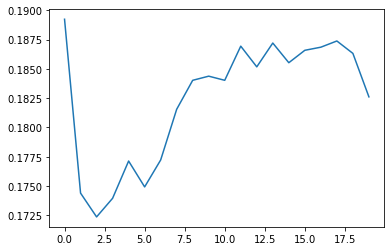

In [37]:
plt.plot(mink_score)

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

*1. Косинусная метрика*

In [38]:
%time cosine_score = cv_score(text_matrix, target, clf_metric='cosine', n=20)

Iteration : 1
Iteration : 2
Iteration : 3
Iteration : 4
Iteration : 5
Iteration : 6
Iteration : 7
Iteration : 8
Iteration : 9
Iteration : 10
Iteration : 11
Iteration : 12
Iteration : 13
Iteration : 14
Iteration : 15
Iteration : 16
Iteration : 17
Iteration : 18
Iteration : 19
Iteration : 20
Wall time: 40min 24s


In [39]:
cosine_score

[0.2557886042005935,
 0.24261932166552824,
 0.2404091933762892,
 0.24270766868022872,
 0.24182316742748208,
 0.24164691864828783,
 0.23855343738315113,
 0.23740452781028107,
 0.2384656996582072,
 0.238907575337038,
 0.24058630922167545,
 0.24217751628936166,
 0.23987965027517869,
 0.23881897054590207,
 0.2380234490318339,
 0.23749324977252403,
 0.23581376599280154,
 0.23607899451067424,
 0.23466492672259573,
 0.23466462207771746]

*Оптимальное число соседей:*

In [44]:
np.asarray(cosine_score[1:]).argmax() + 2

4

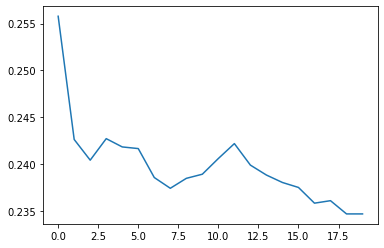

In [45]:
plt.plot(cosine_score)

*2. Tfidf векторизация*

In [74]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=0.01)

In [75]:
tfidf_matrix = tfidf_vectorizer.fit_transform(data).toarray()

*2.1 Tfidf векторизация и евклидова метрика*

In [85]:
%time tfidf_mink_score = cv_score(tfidf_matrix, target, n=20)

Iteration : 1
Iteration : 2
Iteration : 3
Iteration : 4
Iteration : 5
Iteration : 6
Iteration : 7
Iteration : 8
Iteration : 9
Iteration : 10
Iteration : 11
Iteration : 12
Iteration : 13
Iteration : 14
Iteration : 15
Iteration : 16
Iteration : 17
Iteration : 18
Iteration : 19
Iteration : 20
Wall time: 5h 20min 30s


In [86]:

tfidf_mink_score

[0.20832544771783024,
 0.14901882321026524,
 0.1578570866819664,
 0.15388027587515332,
 0.15273099135474077,
 0.150432961301008,
 0.14716262196692043,
 0.1430081797618502,
 0.14044508522979457,
 0.13726313977885032,
 0.13620274126023055,
 0.13496529719888875,
 0.1310766693672263,
 0.13054623576570243,
 0.12904368035759495,
 0.12895528647445167,
 0.1279831881020896,
 0.12603856954138012,
 0.12497772577255363,
 0.12391699917483419]

*Оптимальное число соседей:*

In [87]:
np.asarray(tfidf_mink_score)[1:].argmax() + 2

3

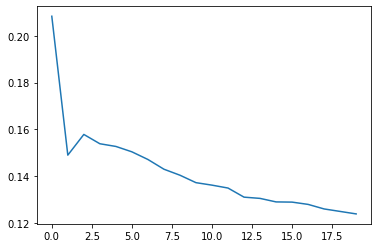

In [88]:
plt.plot(tfidf_mink_score)

*2.2 Tfidf векторизация и косинусная метрика*

In [48]:
%time tfidf_cosine_score = cv_score(tfidf_matrix, target, clf_metric='cosine', n=20)

Iteration : 1
Iteration : 2
Iteration : 3
Iteration : 4
Iteration : 5
Iteration : 6
Iteration : 7
Iteration : 8
Iteration : 9
Iteration : 10
Iteration : 11
Iteration : 12
Iteration : 13
Iteration : 14
Iteration : 15
Iteration : 16
Iteration : 17
Iteration : 18
Iteration : 19
Iteration : 20
Wall time: 39min 52s


In [49]:
tfidf_cosine_score

[0.4113485513292406,
 0.39269945732904804,
 0.40312890443421406,
 0.4129402270813549,
 0.4192149507707937,
 0.4205408824521644,
 0.4250488298871436,
 0.4265510337819299,
 0.4294677975834444,
 0.42858385875201144,
 0.4289376920610201,
 0.43203084524705715,
 0.4361850296756919,
 0.4348589573889928,
 0.4348591917312068,
 0.4369805277555387,
 0.4343288518665685,
 0.4341521578371676,
 0.43459424442399114,
 0.435478183255424]

*Оптимальное число соседей :*

In [50]:
np.asarray(tfidf_cosine_score)[1:].argmax() + 2

16

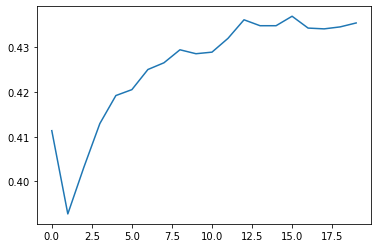

In [51]:
plt.plot(tfidf_cosine_score)

*Лучшая модель с использованием косинусной метрики и Tfidf векторизации!*

*Качество с использованием косинусной метрики слегка улучшается, а с использованием Tfidf векторизации улучшается значительно*

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [76]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [77]:
test_data, test_target = newsgroups['data'], newsgroups['target']

In [78]:
test_matrix = tfidf_vectorizer.transform(test_data).toarray()

In [81]:
final_clf = MyKNeighborsClassifier(n_neighbors=16,algorithm='brute')

In [82]:
final_clf.fit(tfidf_matrix, target)

In [83]:
prediction = final_clf.predict(test_matrix, metric='cosine')

In [84]:
accuracy_score(prediction, test_target)

0.3947158789166224

Да, качество хуже, чем на кросс-валидации.
Вывод : тестовая выборка может быть не репрезентативной.